In [2]:
import pickle
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import re
import matplotlib.pyplot as plt
import scipy.stats as st

# Logistic Regression Results

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, auc

In [98]:
with open("output/base_loss.pkl", "rb") as f:
    base_loss_values = pickle.load(f)

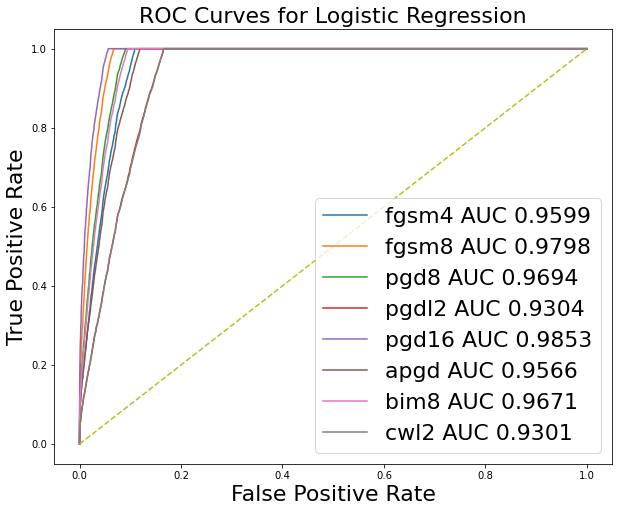

In [102]:
attacks = ["fgsm4", "fgsm8", "pgd8", "pgdl2", "pgd16", "apgd", "bim8", "cwl2"]

plt.figure(figsize=(10, 8))
samp_a = np.sort(base_loss_values)
# p = 1. * np.arange(len(samp_a)) / (len(samp_a) - 1)
# plt.plot(samp_a, p, label="base loss cdf")

confusion_matrices = {}

for attack in attacks:
    path = "output/" + attack + "_mixed2.pkl"
    with open(path, "rb") as f:
        samp_b = np.sort(pickle.load(f))
    samp_b_clean = np.sort(samp_b[0:len(samp_a)])
    samp_b_attack = np.sort(samp_b[len(samp_a):])

    X = np.concatenate((samp_a, samp_b))
    X = np.vstack((X, np.ones(len(X)))).transpose()
    y = np.concatenate((np.zeros(len(samp_a) + len(samp_b_clean)), np.ones(len(samp_b_attack))))

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88, test_size=0.2)

    clf_reg = LogisticRegression()
    clf_reg.fit(X_train, y_train)
    confusion_matrices[attack] = confusion_matrix(y_test, clf_reg.predict(X_test))

    proba = clf_reg.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, proba)
    
    plt.plot(fpr, tpr, label=f"{attack} AUC {np.round(auc(fpr, tpr), 4)}")

plt.plot([0, 1], ls="--")
plt.title("ROC Curves for Logistic Regression", fontsize=22)
plt.ylabel("True Positive Rate", fontsize=22)
plt.xlabel("False Positive Rate", fontsize=22)
plt.legend(prop={'size':22})
plt.show()

In [103]:
confusion_matrices

{'fgsm4': array([[18454,  1497],
        [ 1635,  8414]], dtype=int64),
 'fgsm8': array([[18904,  1047],
        [  828,  9221]], dtype=int64),
 'pgd8': array([[18624,  1327],
        [ 1258,  8791]], dtype=int64),
 'pgdl2': array([[17839,  2112],
        [ 2696,  7353]], dtype=int64),
 'pgd16': array([[19049,   902],
        [  627,  9422]], dtype=int64),
 'apgd': array([[18343,  1608],
        [ 1803,  8246]], dtype=int64),
 'bim8': array([[18557,  1394],
        [ 1355,  8694]], dtype=int64),
 'cwl2': array([[17829,  2122],
        [ 2743,  7306]], dtype=int64)}

In [111]:
for attack in confusion_matrices:
    tn, fp = confusion_matrices[attack][0]
    fn, tp = confusion_matrices[attack][1]

    # print(attack, "accuracy:", np.round((tp + tn) / (tp + fn + fp + tn), 4))
    # print(attack, "precision:", np.round((tp) / (tp + fp), 4))
    print(attack, "recall:", np.round((tp) / (tp + fn), 4))

fgsm4 recall: 0.8373
fgsm8 recall: 0.9176
pgd8 recall: 0.8748
pgdl2 recall: 0.7317
pgd16 recall: 0.9376
apgd recall: 0.8206
bim8 recall: 0.8652
cwl2 recall: 0.727


# Batch p-val results:

In [3]:
def ks_plot_comp(data_1, data_2):
    plt.figure(figsize=(12, 7))
    plt.scatter(data_1, range(len(data_1)), label="base loss", alpha=0.3, s=2)
    plt.scatter(data_2, range(len(data_2)), label="attack loss", alpha=0.3, s=2)
    plt.legend('top right')
    plt.title('Comparing 2 data distributions for KS-Test')
    plt.show()
    
def batch_pvals(loss1, loss2):
    batch_size = 16
    stats = []
    pvals = []
    for i in range(0, len(loss2), batch_size):
        loss_batch2 = loss2[i:i+batch_size]
        result = ks_2samp(loss1, loss_batch2, alternative="greater")
        stats.append(result[0])
        pvals.append(result[1])
    return stats, pvals

In [4]:
with open("output/base_loss.pkl", "rb") as f:
    base_loss_values = pickle.load(f)

In [78]:
attacks = ["fgsm4", "fgsm8", "pgd8", "pgdl2", "pgd16", "apgd", "bim8", "cwl2"]

In [79]:
pvalues = {}

for attack in attacks:
    path = "output/" + attack + "_mixed2.pkl"
    with open(path, "rb") as f:
        data = pickle.load(f)
    
    clean_data = data[:len(base_loss_values)]
    attacked_data = data[len(base_loss_values):]
    s1, p1 = batch_pvals(base_loss_values, clean_data)
    s2, p2 = batch_pvals(base_loss_values, attacked_data)

    pvalues[attack] = (p1, p2)

In [80]:
len(pvalues)

8

In [81]:
pvalues.keys()

dict_keys(['fgsm4', 'fgsm8', 'pgd8', 'pgdl2', 'pgd16', 'apgd', 'bim8', 'cwl2'])

In [96]:
p_cutoff = 0.001
classes = {}

for key in pvalues.keys():
    p1, p2 = pvalues[key]
    tn = np.array(p1) > p_cutoff
    fp = np.array(p1) <= p_cutoff
    tp = np.array(p2) <= p_cutoff
    fn = np.array(p2) > p_cutoff

    accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
    recall = (sum(tp) / (sum(tp) + sum(fn)))
    precision = sum(tp) / (sum(tp) + sum(fp))

    # print(str(key), sum(tn), sum(fp), sum(tp), sum(fn))
    print(str(key), "accuracy: ", accuracy)
    print(str(key), "sensitivity: ", recall)
    print(str(key), "precision: ", precision)

    classes[key] = (sum(tn), sum(fp), sum(tp), sum(fn))

fgsm4 accuracy:  0.76336
fgsm4 sensitivity:  0.94272
fgsm4 precision:  0.6938294865756006
fgsm8 accuracy:  0.78864
fgsm8 sensitivity:  0.99328
fgsm8 precision:  0.7048138056312443
pgd8 accuracy:  0.78048
pgd8 sensitivity:  0.97696
pgd8 precision:  0.7013553870893636
pgdl2 accuracy:  0.67152
pgdl2 sensitivity:  0.75904
pgdl2 precision:  0.6459694989106753
pgd16 accuracy:  0.78976
pgd16 sensitivity:  0.99552
pgd16 precision:  0.7052822489231467
apgd accuracy:  0.744
apgd sensitivity:  0.904
apgd precision:  0.6848484848484848
bim8 accuracy:  0.77888
bim8 sensitivity:  0.97376
bim8 precision:  0.7006677411927239
cwl2 accuracy:  0.67008
cwl2 sensitivity:  0.75616
cwl2 precision:  0.6450996450996451


In [91]:
# tn, fp, tp, fn
classes

{'fgsm4': (2037, 1088, 2873, 252),
 'fgsm8': (2037, 1088, 3080, 45),
 'pgd8': (2037, 1088, 2995, 130),
 'pgdl2': (2037, 1088, 2192, 933),
 'pgd16': (2037, 1088, 3096, 29),
 'apgd': (2037, 1088, 2710, 415),
 'bim8': (2037, 1088, 2968, 157),
 'cwl2': (2037, 1088, 2193, 932)}

In [92]:
def plot_roc_curve(true_label, p1, p2):
    fpr = []
    tpr = []
    thresholds = np.arange(0, 1.0, 0.00001)
    P = sum(true_label)
    N = len(true_label) - P
    for thres in thresholds:
        # tn = np.array(p1) > thres
        fp = np.array(p1) <= thres
        tp = np.array(p2) <= thres
        # fn = np.array(p2) > thres
        fpr.append(sum(fp) / N)
        tpr.append(sum(tp) / P)

    auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr, clip_on=False, lw=2)
    plt.plot([0, 1], ls="--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title(f"ROC curve, AUC={auc}")
    plt.show()

    print(len(fpr))
    print(len(tpr))
    print(len(thresholds))
    return fpr, tpr

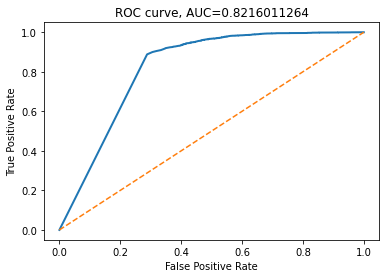

101000
101000
101000


In [93]:
true_label = np.concatenate((np.zeros(len(pvalues["fgsm4"][0])), np.ones(len(pvalues["fgsm4"][0]))))
fpr, tpr = plot_roc_curve(true_label, pvalues["fgsm4"][0], pvalues["fgsm4"][1])